In [1]:
import mtcnn
from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
from glob import glob

from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K

In [2]:
FOLDER_PATH = '.'
IMG_SIZE = 160

In [3]:
detector = MTCNN()
path_train = sorted(glob(os.path.join(FOLDER_PATH, '5celeb/data/train/*/*.jpg')))
path_val = sorted(glob(os.path.join(FOLDER_PATH, '5celeb/data/val/*/*.jpg')))
len(path_train), len(path_val)

(93, 25)

In [4]:
print(path_train[0].split(os.sep)[-2])
names = []
for path in path_train:
    name = path.split(os.sep)[-2]
    if name not in names:
        names.append(name)
names

ben_afflek


['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']

In [5]:
cls_map = {}
for i,n in enumerate(names):
    cls_map[n] = i
cls_map

{'ben_afflek': 0,
 'elton_john': 1,
 'jerry_seinfeld': 2,
 'madonna': 3,
 'mindy_kaling': 4}

In [10]:
# load X: img, y: labels
def load_data(paths):
    X = np.zeros((len(paths), IMG_SIZE, IMG_SIZE, 3))
    y = np.zeros((len(paths), 1))
    # tqdm -> 進度條
    for i, path in enumerate(tqdm(paths)):
        img = cv2.imread(path)[:,:,::-1]
        results = detector.detect_faces(img)
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        # 取出臉部圖片
        patch = img[max(y1, 0): min(y2, img.shape[0]), max(x1, 0): min(x2, img.shape[1])]
        # resize face
        patch = cv2.resize(patch, (IMG_SIZE, IMG_SIZE))
        name = path.split(os.sep)[-2]
        X[i] = patch
        y[i] = cls_map[name]
    return X, y

In [11]:
X_train, y_train = load_data(path_train)
X_val, y_val = load_data(path_val)

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [12]:
X_train = X_train / 255.
X_val = X_val / 255.

[0.] ben_afflek


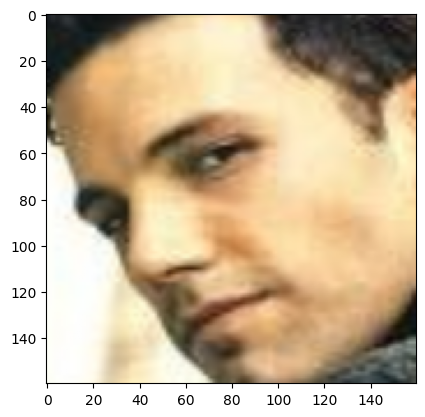

[0.] ben_afflek


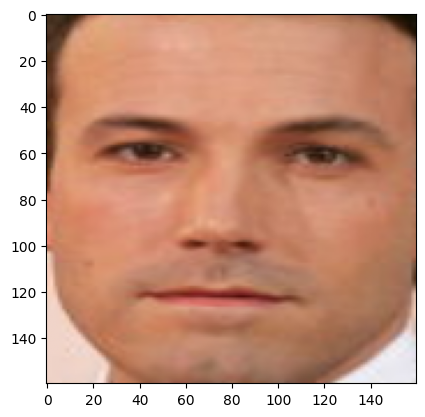

[0.] ben_afflek


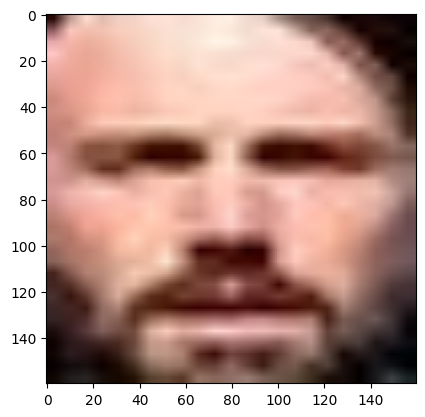

[0.] ben_afflek


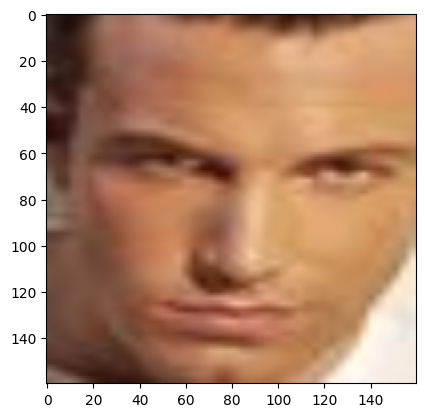

[0.] ben_afflek


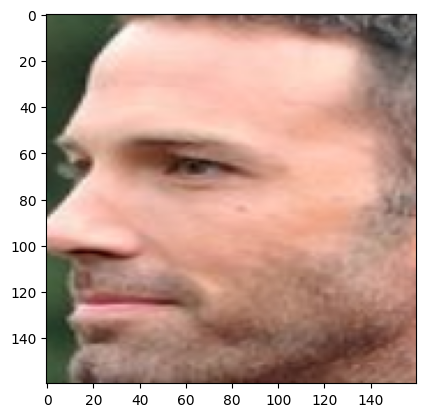

In [13]:
# 看一下截取出來的人臉
for i in range(X_train.shape[0])[:5]:
    print(y_train[i], names[int(y_train[i][0])])
    plt.imshow(X_train[i])
    plt.show()

In [19]:
def create_pairs(x, face_indices, num_classes):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(face_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            # positive pairs
            z1, z2 = face_indices[d][i], face_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            # negative pairs
            inc = np.random.randint(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = face_indices[d][i], face_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

# create training+test positive and negative pairs
face_indices = [np.where(y_train == i)[0] for i in range(len(names))]
train_pairs, train_y = create_pairs(X_train, face_indices, num_classes=len(names))

face_indices = [np.where(y_val == i)[0] for i in range(len(names))]
val_pairs, val_y = create_pairs(X_val, face_indices, num_classes=len(names))

In [20]:
train_pairs.shape, train_y.shape, val_pairs.shape, val_y.shape

((130, 2, 160, 160, 3), (130,), (40, 2, 160, 160, 3), (40,))

In [21]:
train_y = train_y.astype(np.float64)
val_y = val_y.astype(np.float64)

In [27]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 5
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true*square_pred+(1-y_true)*margin_square)
    

In [22]:
K.epsilon()

1e-07

In [63]:
# build model
base_network = keras.applications.resnet50.ResNet50(include_top=False, weights= None
              , input_shape=(IMG_SIZE, IMG_SIZE,3))
    
input_a = Input(shape=(IMG_SIZE, IMG_SIZE,3))
input_b = Input(shape=(IMG_SIZE, IMG_SIZE,3))

global_avg = GlobalAveragePooling2D()

processed_a = base_network(input_a)
processed_a = global_avg(processed_a)

processed_b = base_network(input_b)
processed_b = global_avg(processed_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model = Model([input_a, input_b], distance)

In [64]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 5, 5, 2048)   23587712    input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 2048)         0           resnet50[0][0]             

In [65]:
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [66]:
earlystop = EarlyStopping(patience=10)
model_ckp = ModelCheckpoint(os.path.join("model_siamese.h5"), save_best_only=True, save_weights_only=False)

model.compile(loss=contrastive_loss, optimizer='adam', metrics=[])

model.fit([train_pairs[:,0], train_pairs[:,1]],train_y,
         batch_size=32,
         epochs=1000,
         callbacks=[earlystop, model_ckp],
         validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

Epoch 1/1000
5/5 [==============================] - 4s 239ms/step - loss: 117.0050 - val_loss: 11.5839
Epoch 2/1000
5/5 [==============================] - 0s 96ms/step - loss: 40.1530 - val_loss: 11.4668
Epoch 3/1000
5/5 [==============================] - 0s 92ms/step - loss: 18.3384 - val_loss: 11.3121
Epoch 4/1000
5/5 [==============================] - 0s 92ms/step - loss: 9.0431 - val_loss: 11.2200
Epoch 5/1000
5/5 [==============================] - 0s 93ms/step - loss: 6.6323 - val_loss: 11.1540
Epoch 6/1000
5/5 [==============================] - 0s 92ms/step - loss: 6.0544 - val_loss: 11.0942
Epoch 7/1000
5/5 [==============================] - 0s 95ms/step - loss: 5.9592 - val_loss: 11.0789
Epoch 8/1000
5/5 [==============================] - 0s 94ms/step - loss: 5.8150 - val_loss: 11.0276
Epoch 9/1000
5/5 [==============================] - 0s 94ms/step - loss: 5.5788 - val_loss: 10.8926
Epoch 10/1000
5/5 [==============================] - 0s 92ms/step - loss: 5.2936 - val_loss: 10

In [34]:
# # load model
# # method1: compile=False
# # model = load_model('model.h5', compile=False)
# # method 2
# model = load_model('model.h5', 
#                    custom_objects={'contrastive_loss': contrastive_loss})

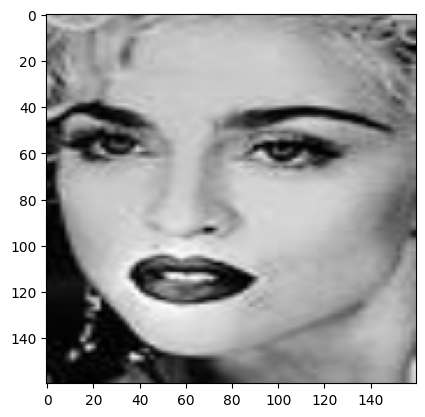

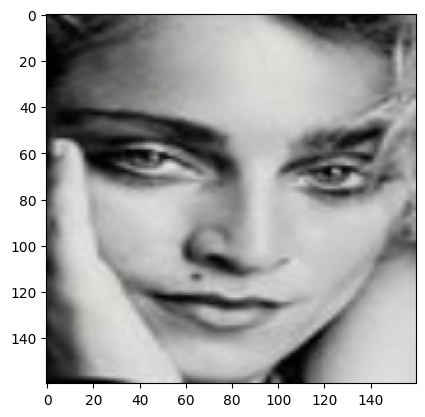

label:  1.0  val data shape:  (1, 2, 160, 160, 3)
Distance:  [[5.9695935]]


In [67]:
# Evaluation
idx = np.random.randint(0, val_pairs.shape[0])
pair = val_pairs[idx]
label = val_y[idx]
imgA, imgB = pair[0], pair[1]
plt.imshow(imgA)
plt.show()
plt.imshow(imgB)
plt.show()
print('label: ', label, ' val data shape: ',val_pairs[idx:idx+1].shape)
print('Distance: ', model.predict([np.expand_dims(imgA, axis=0), np.expand_dims(imgB, axis=0)]))

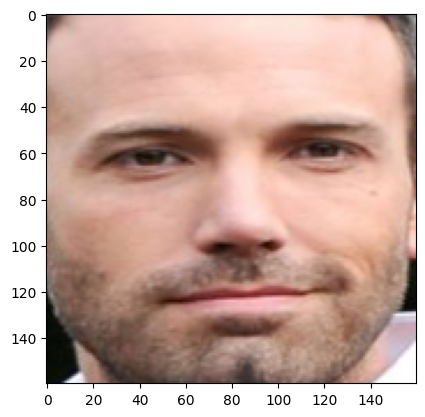

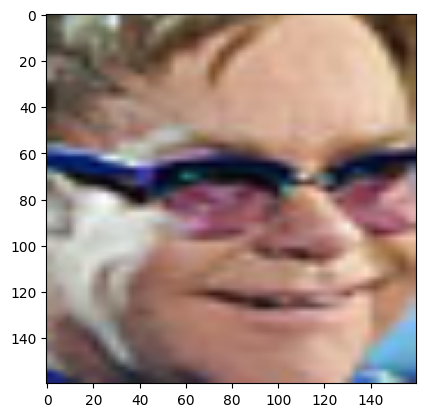

label:  0.0  val data shape:  (1, 2, 160, 160, 3)
Distance:  [[1.5016005]]


In [73]:
# Evaluation
idx = np.random.randint(0, val_pairs.shape[0])
pair = val_pairs[idx]
label = val_y[idx]
imgA, imgB = pair[0], pair[1]
plt.imshow(imgA)
plt.show()
plt.imshow(imgB)
plt.show()
print('label: ', label, ' val data shape: ',val_pairs[idx:idx+1].shape)
print('Distance: ', model.predict([np.expand_dims(imgA, axis=0), np.expand_dims(imgB, axis=0)]))

In [69]:
all_pairs = np.concatenate((train_pairs, val_pairs))
all_labels = np.concatenate((train_y, val_y))

In [70]:
positive_pairs = all_pairs[all_labels == 1] 
negative_pairs = all_pairs[all_labels == 0]

In [71]:
positive_distances = model.predict([positive_pairs[:, 0], positive_pairs[:, 1]])
negative_distances = model.predict([negative_pairs[:, 0], negative_pairs[:, 1]])

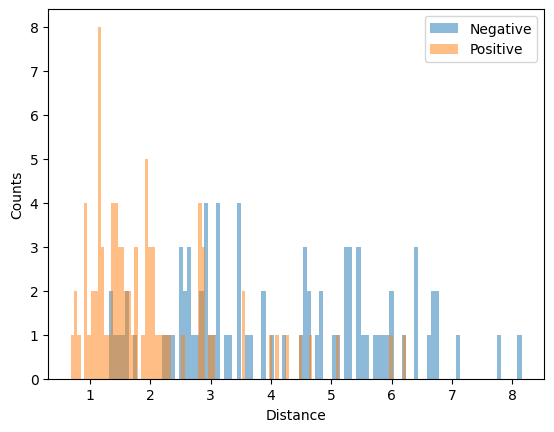

In [72]:
plt.hist(negative_distances[:,0], bins=100, alpha=0.5)
plt.hist(positive_distances[:,0], bins=100, alpha=0.5)
plt.legend(['Negative', 'Positive'])
plt.xlabel('Distance')
plt.ylabel('Counts')
plt.show()